In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.adiabatic_pulse_calib
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qub

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
# expt_path=os.getcwd()+'\data\data_220904'
# expt_path=os.getcwd()+'\data\data_220919'
# expt_path=os.getcwd()+'\data\data_221215'
# expt_path=os.getcwd()+'\data\data_230217'
expt_path=os.getcwd()+'\data\data_230717'
print('Data will be stored in', expt_path)

Data will be stored in c:\_Lib\python\rfsoc\qram_4QR2_BF5\data\data_230717


In [6]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be c:\_Lib\python\rfsoc\qram_4QR2_BF5\config_q3diamond_full688and638_reset.yml


Load config

In [7]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [8]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

In [9]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=399.360 MHz, fs=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_sg_mux4_v2 - tProc output

# Sweep qubits

For each iteration: sweep qubit 0 freq after applying pi pulse to qubit 1

In [10]:
ZZshifts = np.zeros((4,4)) # first dim: qubit 0, second dim: qubit 1

Baseline qspec

In [ ]:
qfreqs = []
qubit0 = 1
for qubit1 in range(1):
# for qubit0 in range(4):
    qspec = meas.PulseProbeCouplingSpectroscopyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"qubit_coupling_spectroscopy_qubit{qubit0}",
        config_file=config_path,
    )
    
    span = 15
    npts = 151
    
    qspec.cfg.expt = dict(
        start=qspec.cfg.device.qubit.f_ge[qubit0]-span/2,
        # start=3600,
        step=span/npts,
        expts=npts, # Number of experiments stepping from start
        reps=100, # Number of averages per point
        rounds=20, # Number of start to finish sweeps to average over
        pulseB=True, # Whether to apply pi pulse to qubit B
        length=1, # qubit 0 probe constant pulse length [us]
        gain=int(qspec.cfg.device.qubit.pulses.pi_ge.gain[qubit0]/15), # Qubit pulse gain
        pulse_type='gauss',
        qubits=[qubit0, qubit1],
    )
    
    # qspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
    
    # print(qspec.cfg)
    
    qspec.go(analyze=False, display=False, progress=True, save=False)

    # ============ POST PROCESSING ============ #
    best_signs = [1, 0, 0]
    best_fit_err_i = np.inf
    best_fit_err_q = np.inf
    for sign in [1, -1]:
        try: 
            qspec.analyze(fit=True, signs=[1, sign, sign])
            fit_err_amps = qspec.data['fit_err_amps'][2][2]
            fit_err_i = qspec.data['fit_err_avgi'][2][2]
            fit_err_q = qspec.data['fit_err_avgq'][2][2]
            if fit_err_i < best_fit_err_i:
                best_signs[1] = sign
                best_fit_err_i = fit_err_i
            if fit_err_q < best_fit_err_q:
                best_signs[2] = sign
                best_fit_err_q = fit_err_q
        except: continue
    if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
        qspec.display(fit=False)
        print(f'WARNING: All fits failed for Q{qubit0}, please manually fix!')
        continue

    qspec.analyze(fit=True, signs=best_signs)
    qspec.display(fit=True, signs=best_signs)

    qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
    qfreqs.append(qspec_fit[2])
    print(f'Fit Q{qubit0} frequency [MHz]: {qspec_fit[2]}')

print('Qubit freqs', qfreqs)

ZZ shifts

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4124.327416528408, HWHM 0.3183359812656444
Found peak in I at [MHz] 4126.54631590375, HWHM 0.2464482806271261
Found peak in Q at [MHz] 4124.324637087568, HWHM 0.3134637140998418


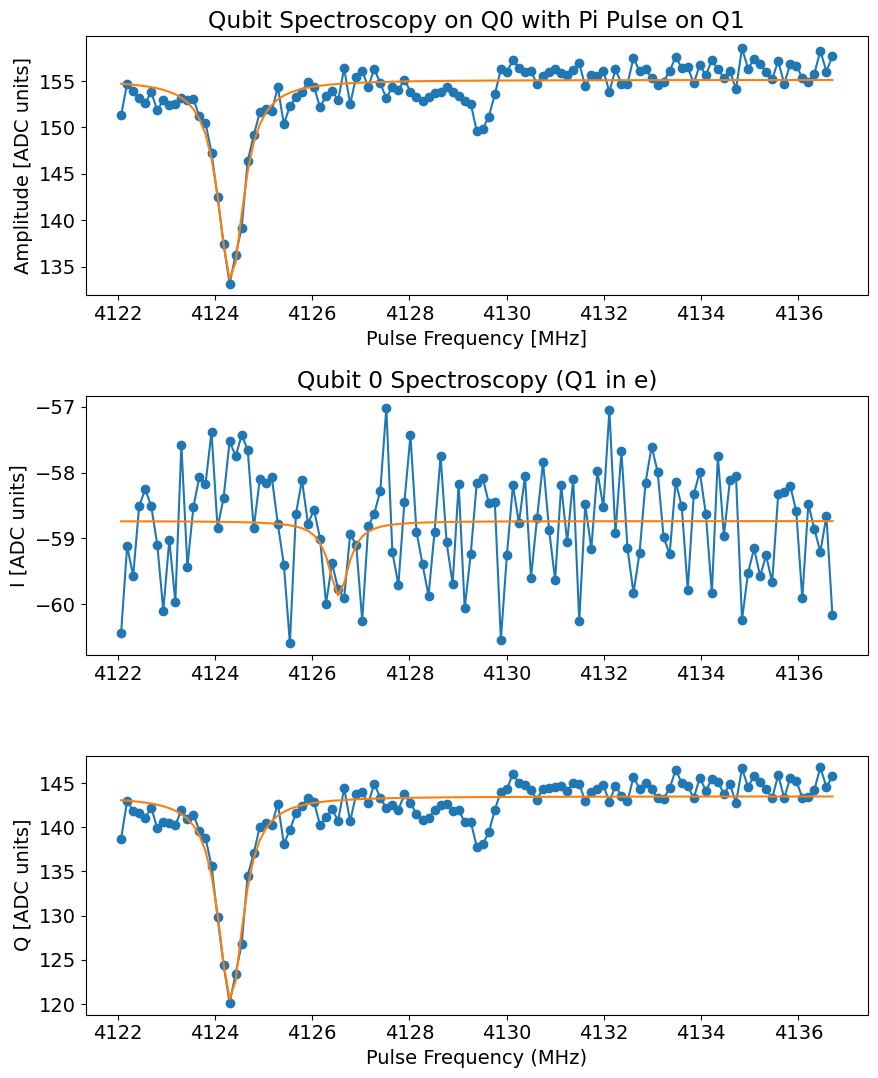

Fit Q0 frequency with ZZ shift [MHz]: 4124.327416528408
Q0 shift due to Q1 in e [MHz]: -5.1194753669242345


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4133.982965683464, HWHM -1.9427459838887688
Found peak in I at [MHz] 4129.322409173866, HWHM -0.18449296595647424
Found peak in Q at [MHz] 4129.299727886593, HWHM 0.22150710449182281


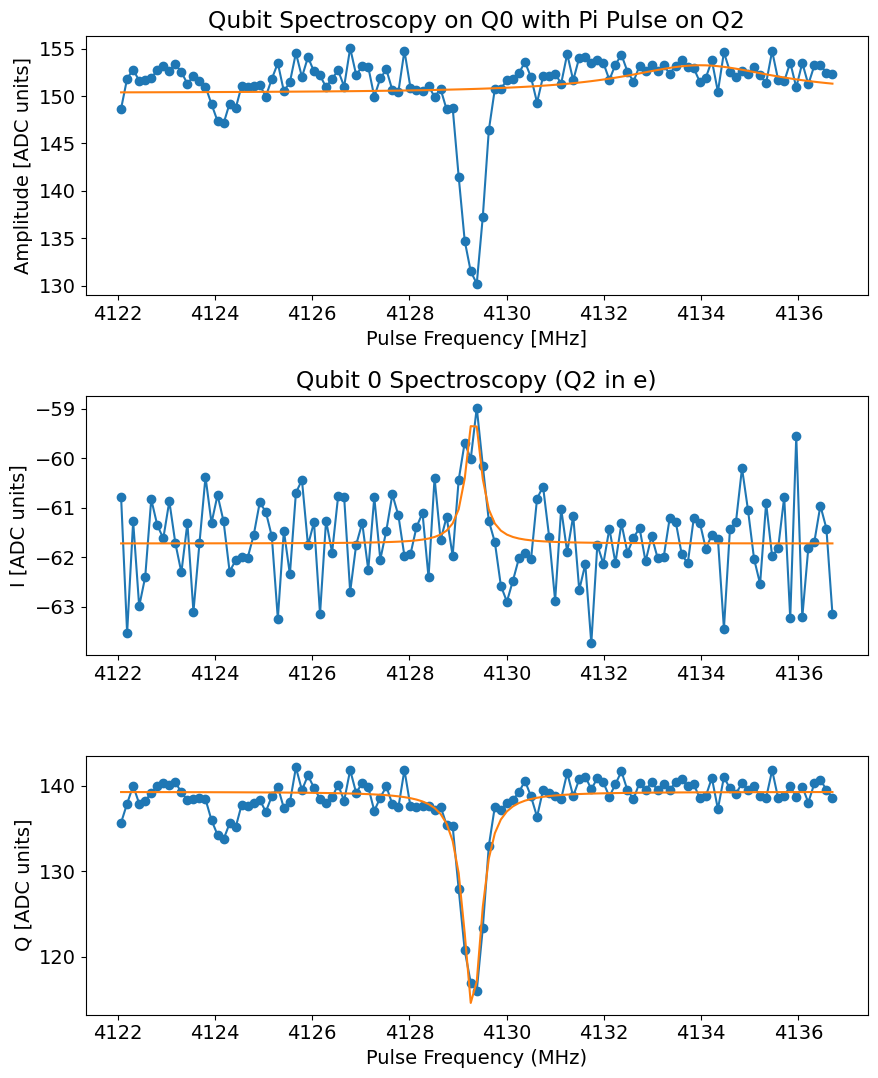

Fit Q0 frequency with ZZ shift [MHz]: 4129.299727886593
Q0 shift due to Q2 in e [MHz]: -0.1471640087393098


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4128.893412988852, HWHM -0.26007624870821705
Found peak in I at [MHz] 4129.018933298399, HWHM 0.4051731157724243
Found peak in Q at [MHz] 4128.89041095983, HWHM -0.2537030606218103


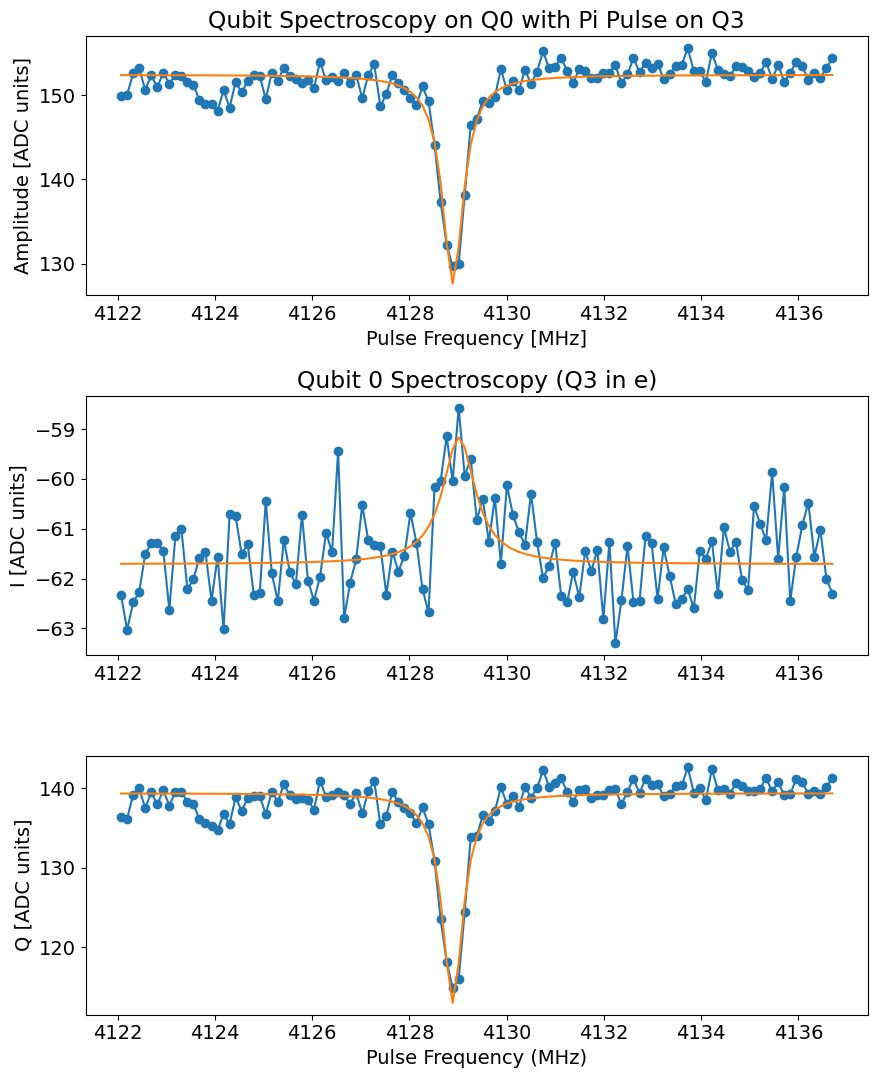

Fit Q0 frequency with ZZ shift [MHz]: 4128.893412988852
Q0 shift due to Q3 in e [MHz]: -0.55347890648045


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3449.896234591444, HWHM 1.1514730856648197
Found peak in I at [MHz] 3449.8780411908247, HWHM 1.1259602268589675
Found peak in Q at [MHz] 3449.9689629538866, HWHM 1.2208948839960343


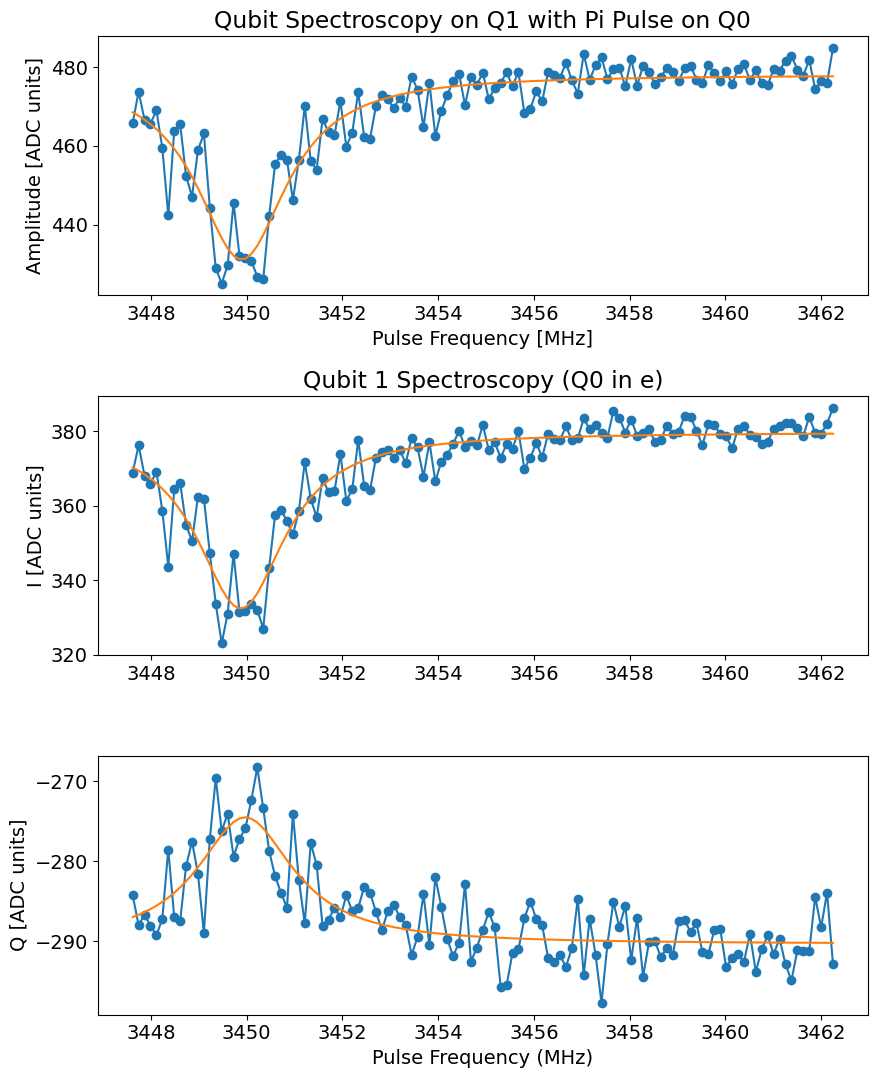

Fit Q1 frequency with ZZ shift [MHz]: 3449.8780411908247
Q1 shift due to Q0 in e [MHz]: -5.118032811305966


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3453.8227534542525, HWHM 1.3862137275887982
Found peak in I at [MHz] 3453.8642047379476, HWHM 1.301907314095615
Found peak in Q at [MHz] 3453.699331596662, HWHM 1.605267324344833


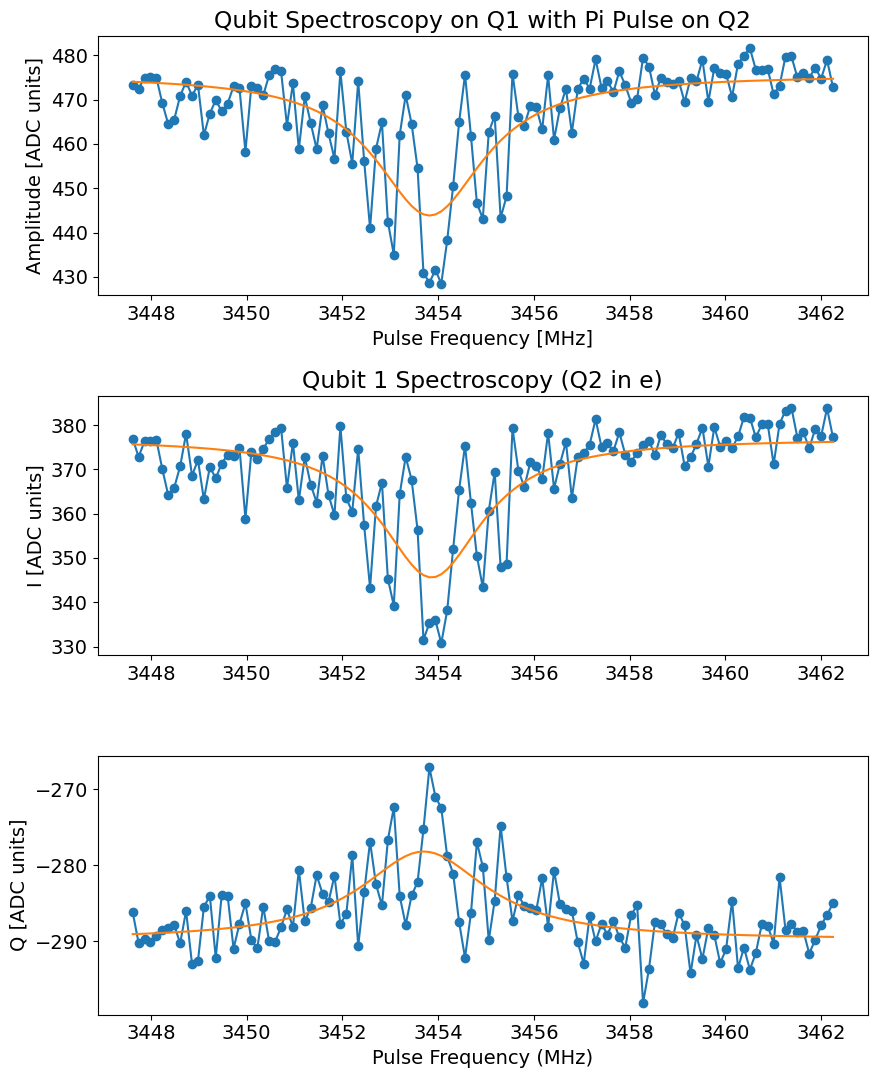

Fit Q1 frequency with ZZ shift [MHz]: 3453.8227534542525
Q1 shift due to Q2 in e [MHz]: -1.1733205478781201


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3453.8511749735676, HWHM 2.131159575749196
Found peak in I at [MHz] 3453.863578921356, HWHM 1.9495418736656716
Found peak in Q at [MHz] 3453.827704072596, HWHM 2.5903273303029506


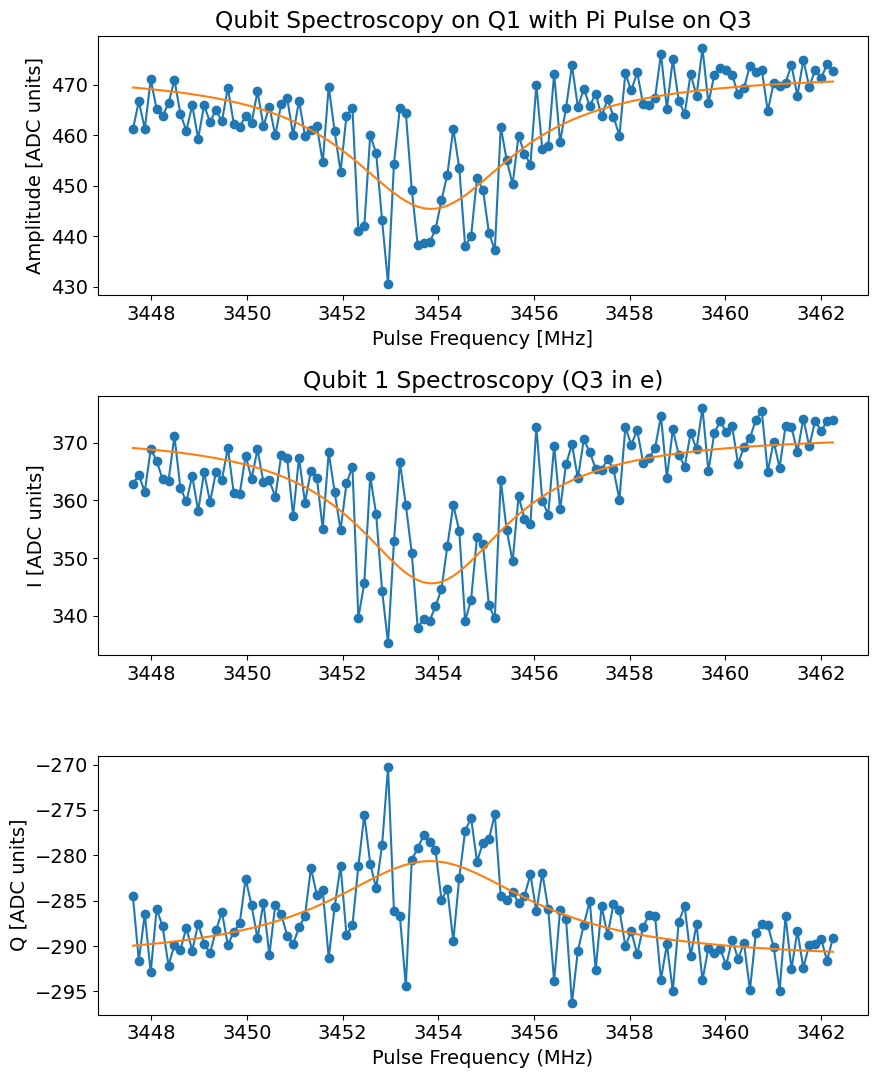

Fit Q1 frequency with ZZ shift [MHz]: 3453.863578921356
Q1 shift due to Q3 in e [MHz]: -1.1324950807747882


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4779.4175339723315, HWHM 0.42942035808967527
Found peak in I at [MHz] 4780.640406542665, HWHM 451.27524162635007
Found peak in Q at [MHz] 4779.416369985244, HWHM 0.43375654669237246


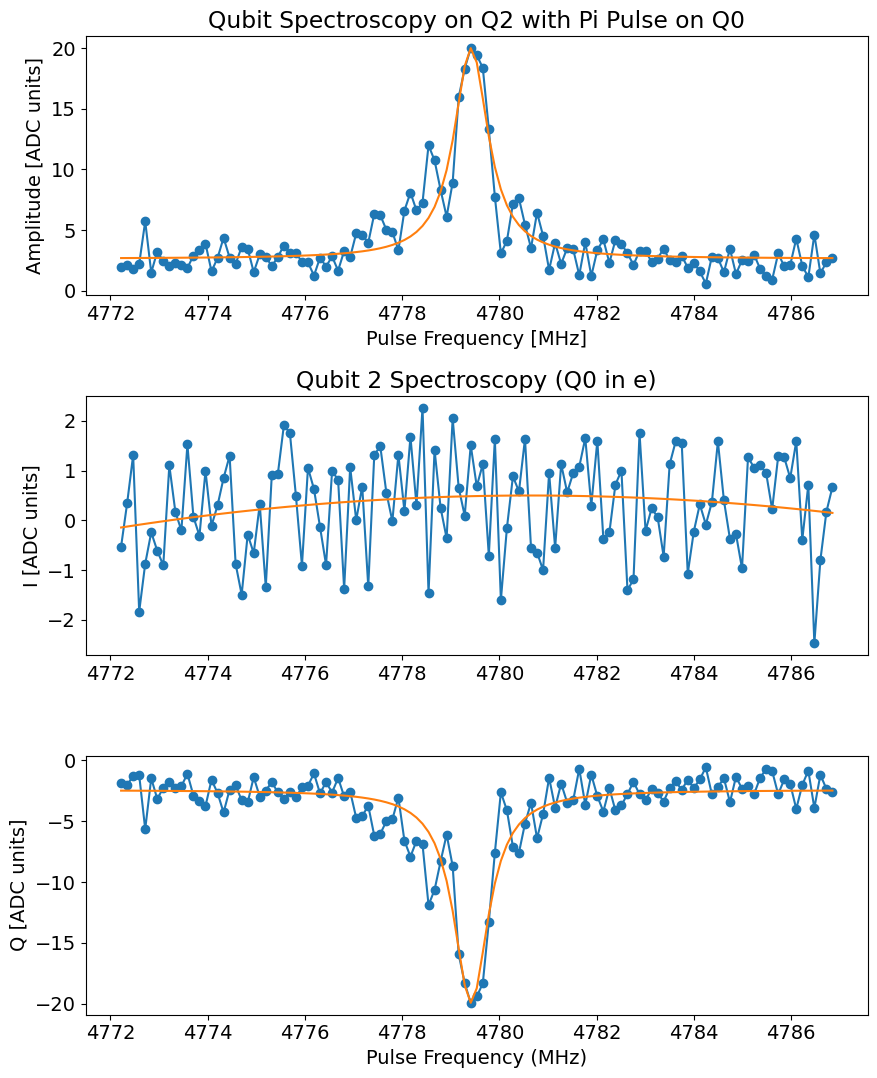

Fit Q2 frequency with ZZ shift [MHz]: 4779.4175339723315
Q2 shift due to Q0 in e [MHz]: -0.17856353780189238


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4778.52747370677, HWHM 0.5272144590634275
Found peak in I at [MHz] 4781.719185971137, HWHM -0.0015134721798488687
Found peak in Q at [MHz] 4778.528910402303, HWHM 0.5480664369219844


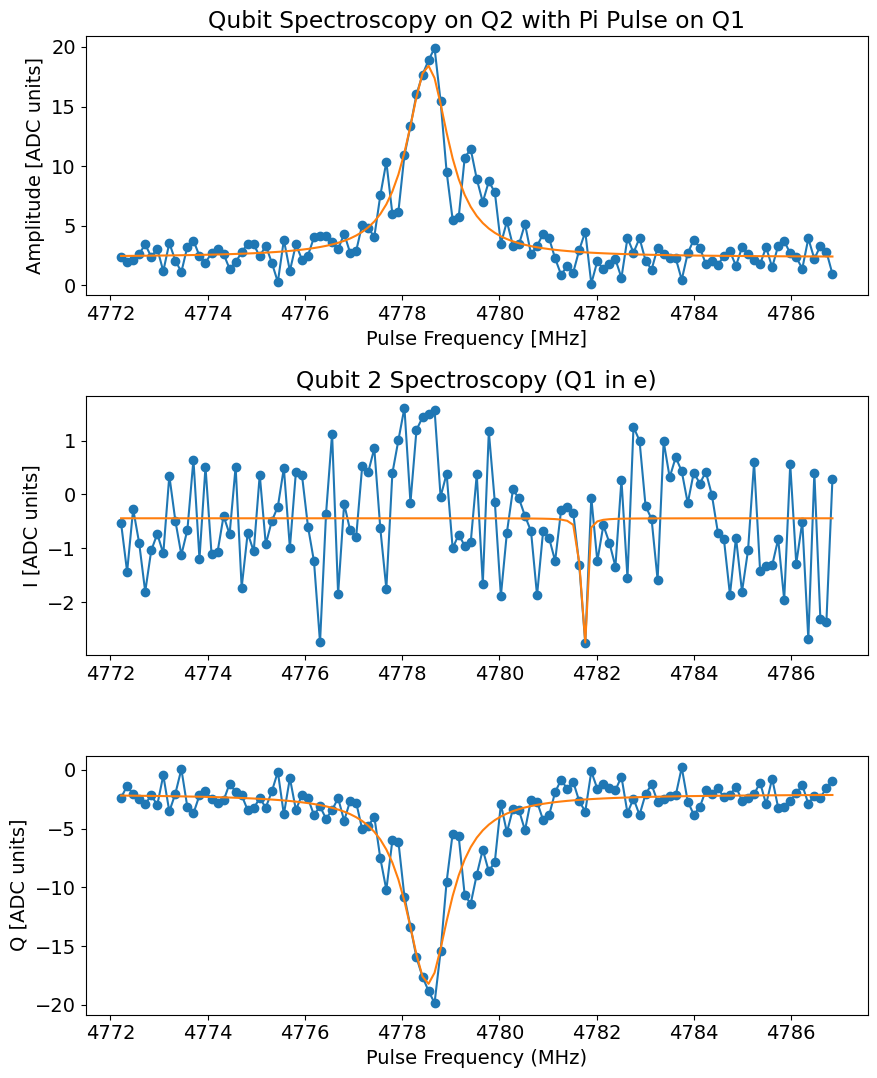

Fit Q2 frequency with ZZ shift [MHz]: 4778.52747370677
Q2 shift due to Q1 in e [MHz]: -1.0686238033631525


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4779.088367643324, HWHM 0.5085057830797635
Found peak in I at [MHz] 4779.100638732095, HWHM -0.3885821454988871
Found peak in Q at [MHz] 4779.086875183283, HWHM 0.531967996683158


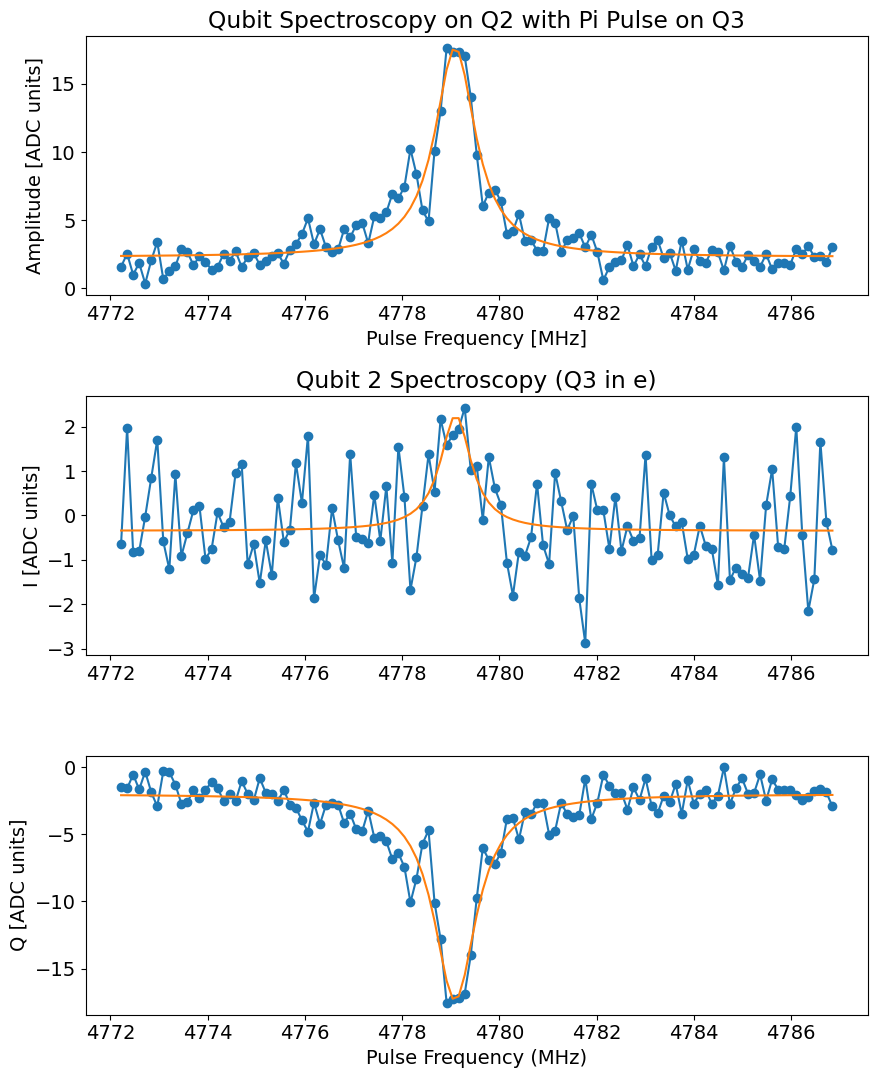

Fit Q2 frequency with ZZ shift [MHz]: 4779.088367643324
Q2 shift due to Q3 in e [MHz]: -0.5077298668093135


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4393.839317368206, HWHM 0.9250516888670157
Found peak in I at [MHz] 4393.859217094898, HWHM 0.8560210391892396
Found peak in Q at [MHz] 4393.830231667534, HWHM 0.9632727270418632


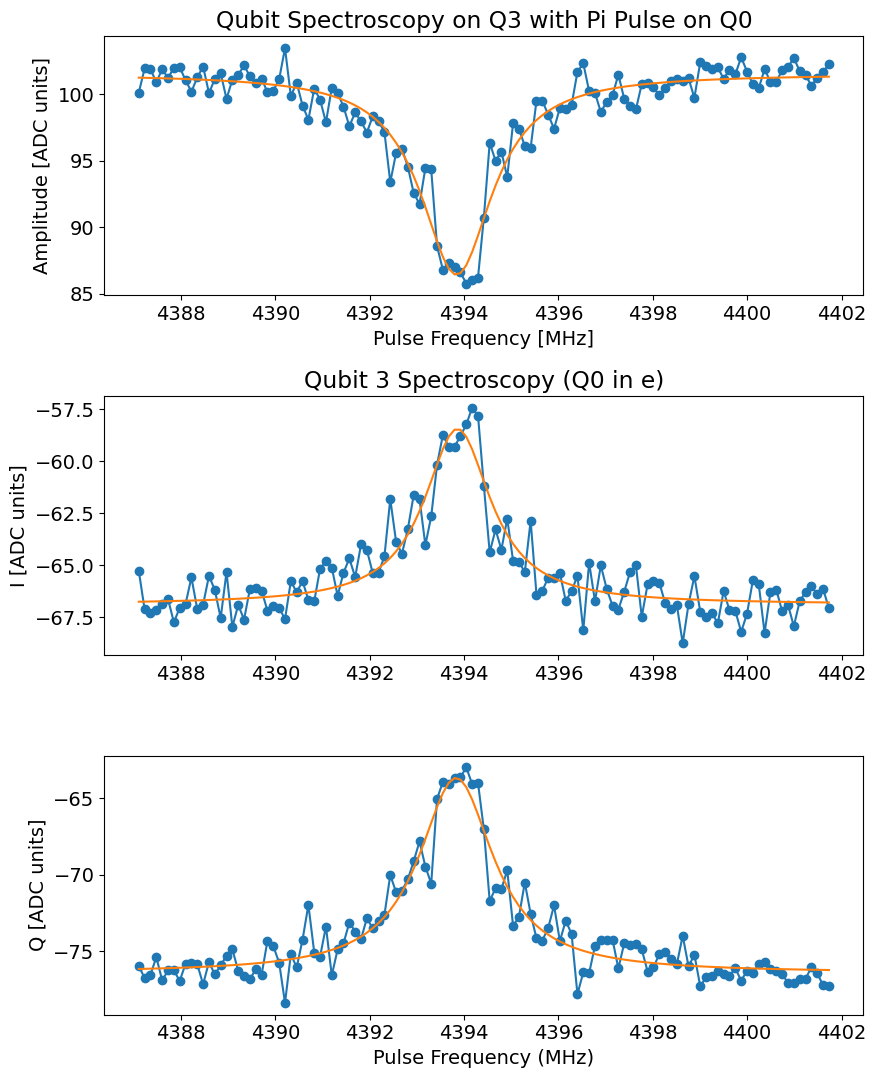

Fit Q3 frequency with ZZ shift [MHz]: 4393.839317368206
Q3 shift due to Q0 in e [MHz]: -0.6410899146294469


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4393.217309963954, HWHM 0.9124045650662689
Found peak in I at [MHz] 4393.1999572910445, HWHM 0.8971365507674446
Found peak in Q at [MHz] 4393.227108308522, HWHM 0.9179614094002584


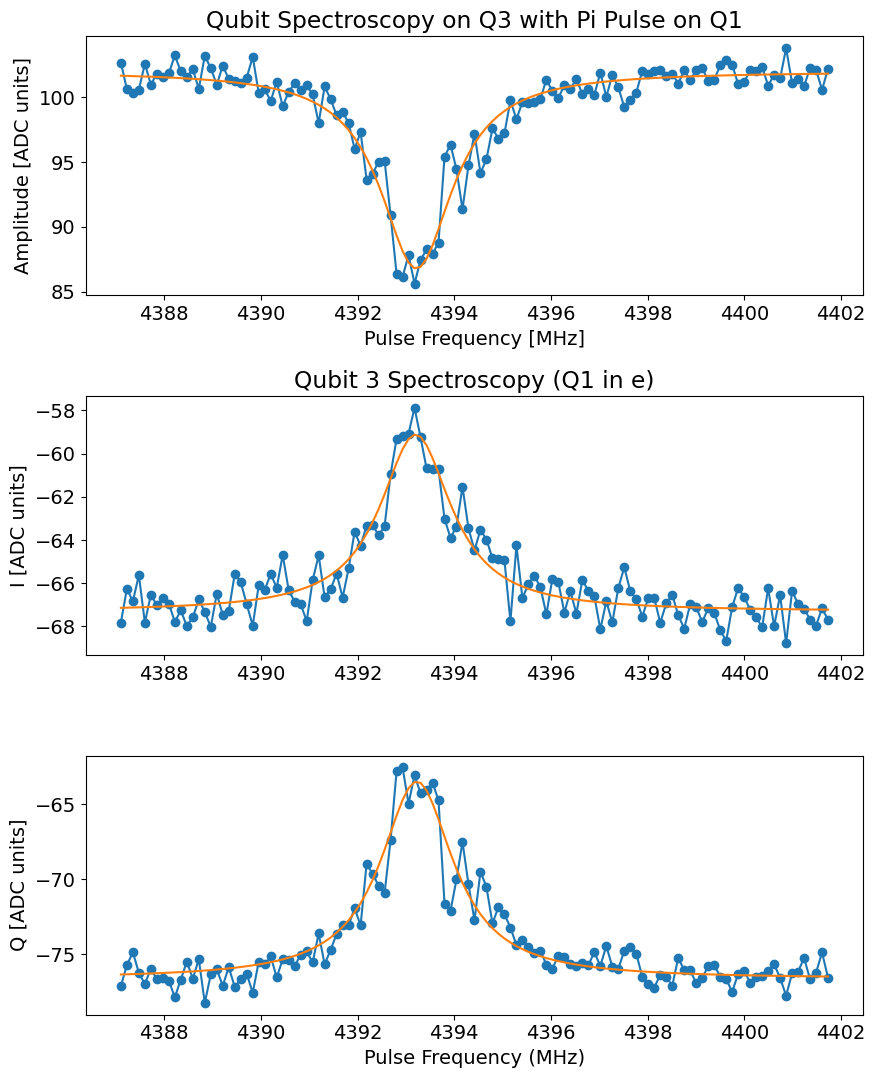

Fit Q3 frequency with ZZ shift [MHz]: 4393.217309963954
Q3 shift due to Q1 in e [MHz]: -1.2630973188815915


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4393.8521344612045, HWHM 0.9035090790666551
Found peak in I at [MHz] 4393.844238824538, HWHM 0.7921942630703485
Found peak in Q at [MHz] 4393.856123288024, HWHM 0.9699344971356506


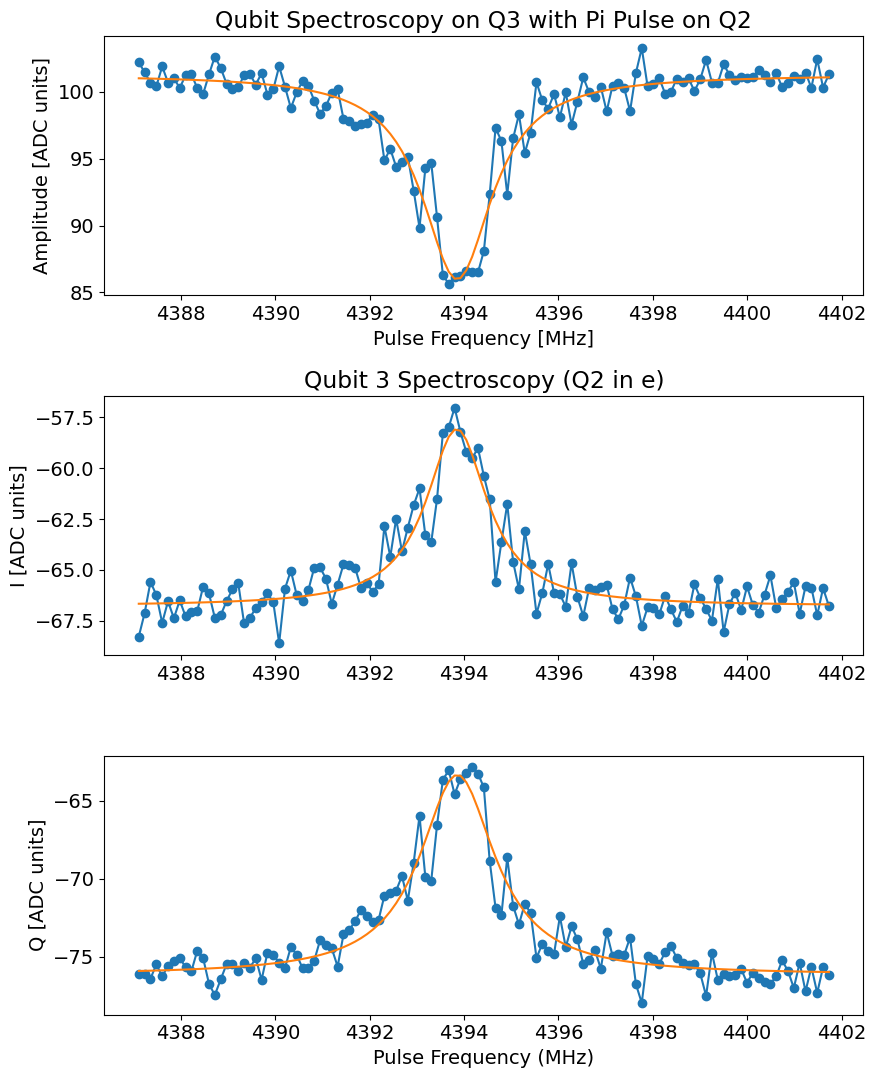

Fit Q3 frequency with ZZ shift [MHz]: 4393.8521344612045
Q3 shift due to Q2 in e [MHz]: -0.6282728216310716
[[ 0.         -5.11947537 -0.14716401 -0.55347891]
 [-5.11803281  0.         -1.17332055 -1.13249508]
 [-0.17856354 -1.0686238   0.         -0.50772987]
 [-0.64108991 -1.26309732 -0.62827282  0.        ]]


In [11]:
for qubit0 in range(4): # qubit to measure
# for qubit0 in range(1): # qubit to measure
    # for qubit1 in range(2): # qubit to pulse to e
    for qubit1 in range(4): # qubit to pulse to e
    # for qubit1 in range(qubit0+1, 4):
        # if qubit0 != 1: continue # UNCOMMENT IF JUST GETTING FREQS FOR Q1 ZZ
        if qubit1 == qubit0: continue
        qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_coupling_spectroscopy_qubit{qubit0}{qubit1}",
            config_file=config_path,
        )
        
        span = 15
        npts = 121
        
        qZZspec.cfg.expt = dict(
            start=qZZspec.cfg.device.qubit.f_ge[qubit0]-span/2, # resonator frequency to be mixed up [MHz]
            # start=3600,
            step=span/npts,
            expts=npts, # Number of experiments stepping from start
            reps=100, # Number of averages per point
            rounds=10, # Number of start to finish sweeps to average over
            pulseB=True, # Whether to apply pi pulse to qubit B
            length=1, # qubit 0 probe constant pulse length [us]
            gain=int(qZZspec.cfg.device.qubit.pulses.pi_ge.gain[qubit0]/5), # pulse gain for qubit we are measuring
            pulse_type='gauss',
            qubits=[qubit0, qubit1],
        )
        
        # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # print(qZZspec.cfg)
        
        qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [1, 0, 0]
        best_fit_err_i = np.inf
        best_fit_err_q = np.inf
        for sign in [1, -1]:
            try: 
                qZZspec.analyze(fit=True, signs=[1, sign, sign])
                fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
                fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
                fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
                if fit_err_i < best_fit_err_i:
                    best_signs[1] = sign
                    best_fit_err_i = fit_err_i
                if fit_err_q < best_fit_err_q:
                    best_signs[2] = sign
                    best_fit_err_q = fit_err_q
            except: continue
        if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
            qZZspec.display(fit=False)
            print(f'WARNING: All fits failed for Q{qubit0} due to Q{qubit1} in e, please manually fix!')
            continue

        qZZspec.analyze(fit=True, signs=best_signs)
        qZZspec.display(fit=True, signs=best_signs)

        qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data)
        ZZshifts[qubit0, qubit1] = qZZspec_fit[2] - qZZspec.cfg.device.qubit.f_ge[qubit0]
        print(f'Fit Q{qubit0} frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        print(f'Q{qubit0} shift due to Q{qubit1} in e [MHz]: {ZZshifts[qubit0, qubit1]}')
print(ZZshifts)

In [14]:
# ZZshifts[0, 1] = 4125.998679041251 - 4131.202186954483
# ZZshifts[0, 2] = -0.22925396
# ZZshifts[0, 3] = -0.58692004
# ZZshifts[2, 0] = ZZshifts[0, 2]
# ZZshifts[2, 1] = 4784.023574653984 + 0.15 - 4785.262727180726
# ZZshifts[2, 3] = -0.49538999
# ZZshifts[3, 0] = -0.58692004
# ZZshifts[3, 1] = ZZshifts[1, 3]
# ZZshifts[3, 2] = ZZshifts[2, 3]
ZZshifts = np.array(
[[ 0.        , -5.11947537, -0.14716401, -0.55347891],
 [-5.11803281,  0.        , -1.17332055, -1.13249508],
 [-0.17856354, -1.0686238 ,  0.        , -0.50772987],
 [-0.64108991, -1.26309732, -0.62827282,  0.        ]])
print(ZZshifts)

[[ 0.         -5.11947537 -0.14716401 -0.55347891]
 [-5.11803281  0.         -1.17332055 -1.13249508]
 [-0.17856354 -1.0686238   0.         -0.50772987]
 [-0.64108991 -1.26309732 -0.62827282  0.        ]]


In [30]:
# f_Q1_ZZ = np.array(yaml_cfg.device.qubit.f_Q1_ZZ)
# f_ge = np.array(yaml_cfg.device.qubit.f_ge)
# # print(f_Q1_ZZ-f_ge[1])

# ZZshifts[1, :] = f_Q1_ZZ - f_ge[1]
# ZZshifts[:, 1] = f_Q1_ZZ - f_ge[1]
# print(ZZshifts)
print(f_ge[:] + ZZshifts[:, 1])

[4124.32741653 3454.996074   4778.52747371 4393.21730996]


In [16]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'ZZs: [', end='')
print(*ZZshifts.flatten(), sep=', ', end='')
print(']')

UPDATE MANUALLY IN CONFIG:
ZZs: [0.0, -5.11947537, -0.14716401, -0.55347891, -5.11803281, 0.0, -1.17332055, -1.13249508, -0.17856354, -1.0686238, 0.0, -0.50772987, -0.64108991, -1.26309732, -0.62827282, 0.0]


In [17]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_Q1_ZZ: [', end='')
print(*(ZZshifts[1] + yaml_cfg.device.qubit.f_ge[1]).flatten(), sep=', ', end=']\n')

UPDATE MANUALLY IN CONFIG:
f_Q1_ZZ: [3449.8780411921307, 3454.9960740021306, 3453.8227534521307, 3453.8635789221307]


# Get couplings by optimization

In [18]:
sys.path.append(os.getcwd()+'/../qutip_sims')
from QSwitch import QSwitch
from scipy.optimize import minimize

In [19]:
# ZZshifts = np.array([[ 0., -0.6, -0.06, 0.12],
#  [-0.5, 0., -4.3, -0.86],
#  [ -0.04, -5.0,  0., -0.21 ],
#  [ -0.25, -0.44, 0.11, 0.]]
# )

In [20]:
# Provide measured qubit freqs (GHz), alphas (GHz), ZZ matrix (GHz)
# For use in optimization
def ZZ_g_diff(gs, *args):
    qubit_freqs, alphas, ZZ_matrix = args
    # print(args)
    qram = QSwitch(
        EJs=None,
        ECs=None,
        gs=gs,
        qubit_freqs=qubit_freqs,
        alphas=alphas,
        cutoffs=[4, 5, 4, 4],
        isCavity=[False]*4,
    )
    # print(qram.get_ZZ_matrix())
    # return np.sum(np.abs(ZZ_matrix - qram.get_ZZ_matrix()))
    return np.sum(np.abs(1e3*(ZZ_matrix - qram.get_ZZ_matrix()))**2)

In [21]:
x0 = np.array([100, 100, 100, 10, 10, 10])
qubit_freqs_MHz = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
alphas_MHz = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq) - qubit_freqs_MHz

print('qubit freqs', qubit_freqs_MHz)
print('alphas', alphas_MHz)
bounds = [(1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1)]

result = minimize(ZZ_g_diff, x0=1e-3*x0, args=(1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts), bounds=bounds , method='L-BFGS-B')

qubit freqs [4129.4468919  3454.996074   4779.59609751 4394.48040728]
alphas [-226.03086971 -100.4749343  -189.41904848 -172.54847801]


In [22]:
print(f'Success: {result.success}')
gs_opt = result.x # GHz
print(f'Optimized g01, g12, g13, g02, g03, g23 [MHz]')
print('gs: [', end='')
print(*(gs_opt*1e3), sep=', ', end=']\n')

print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=gs_opt,
    qubit_freqs=1e-3*qubit_freqs_MHz,
    alphas=1e-3*alphas_MHz,
    cutoffs=[4, 5, 4, 4],
    isCavity=[False]*4,
)
print('Measured ZZ matrix [MHz]')
print(ZZshifts)
print('Optimized ZZ matrix [MHz]')
print(1e3*qram.get_ZZ_matrix())
print(f'Optimization error: {ZZ_g_diff(gs_opt, 1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts)}')

Success: True
Optimized g01, g12, g13, g02, g03, g23 [MHz]
gs: [54.233867058381975, 56.612917931142945, 42.87162116341841, 5.275712018852002, 2.7385639790041876, 6.807578931629736]
ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -5.11947537 -0.14716401 -0.55347891]
 [-5.11803281  0.         -1.17332055 -1.13249508]
 [-0.17856354 -1.0686238   0.         -0.50772987]
 [-0.64108991 -1.26309732 -0.62827282  0.        ]]
Optimized ZZ matrix [MHz]
[[ 0.         -5.11875372 -0.16286366 -0.59728303]
 [-5.11875372  0.         -1.12097287 -1.19779547]
 [-0.16286366 -1.12097287  0.         -0.56800159]
 [-0.59728303 -1.19779547 -0.56800159  0.        ]]
Optimization error: 0.025606328072734913


# ZZ shifted pi pulse calibrations for Q1

In [23]:
save_data = False
saved_files = []

In [24]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [25]:
results = dict(
    gain=[0]*4,
    sigma=[0]*4,
    f_Q1_ZZ=[0]*4,
    )

######### BEGINNING QUBIT 0 #########
-------- length rabi --------


  0%|          | 0/101 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 202.1376, which is out of bounds 0.43442424242424243 to 65.16363636363636. Instead init to 32.7990303030303
Decay from avgi [us] 0.0748676271959733
Pi length from avgi data [us]: 0.014606421909355634
	Pi/2 length from avgi data [us]: 0.007303210954677817

Decay from avgq [us] 0.20824788610058412
Pi length from avgq data [us]: 0.014783948300903934
Pi/2 length from avgq data [us]: 0.007391974150451967


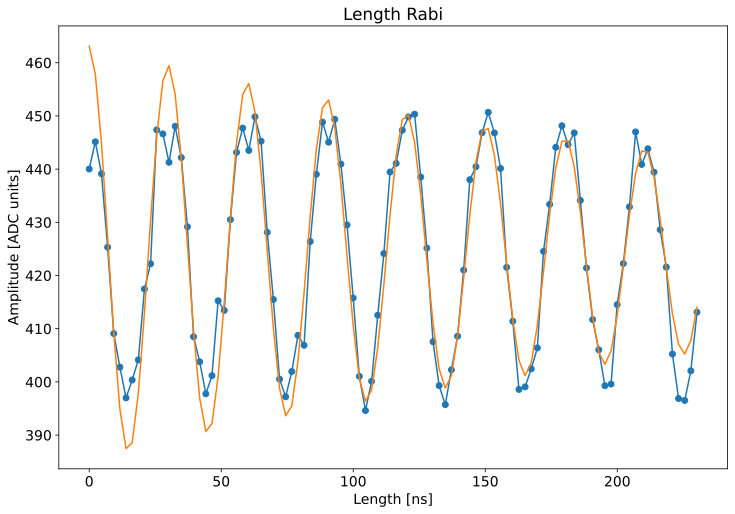

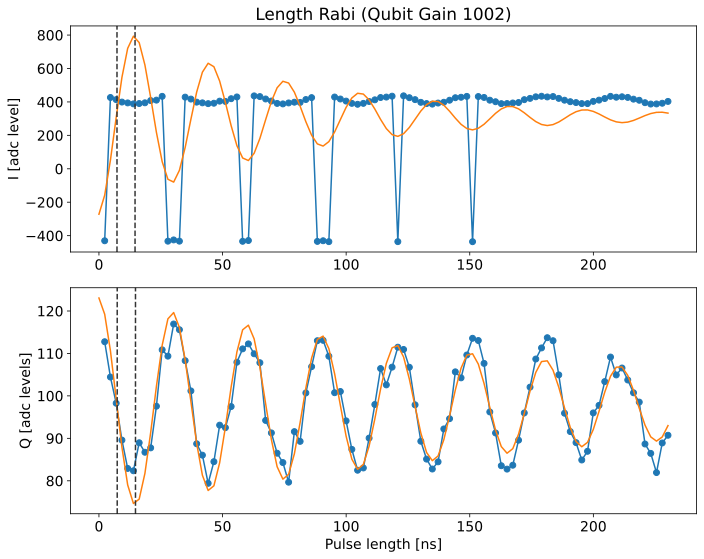

Will use sigma 0.015 for amplitude rabi
-------- Amp rabi --------
gauss


  0%|          | 0/30 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 994
	Pi/2 gain from amps data [dac units]: 497
Pi gain from avgi data [dac units]: 994
	Pi/2 gain from avgi data [dac units]: 497
Pi gain from avgq data [dac units]: 997
	Pi/2 gain from avgq data [dac units]: 498


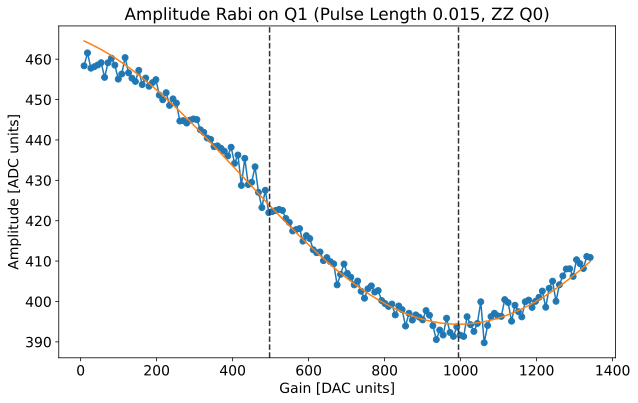

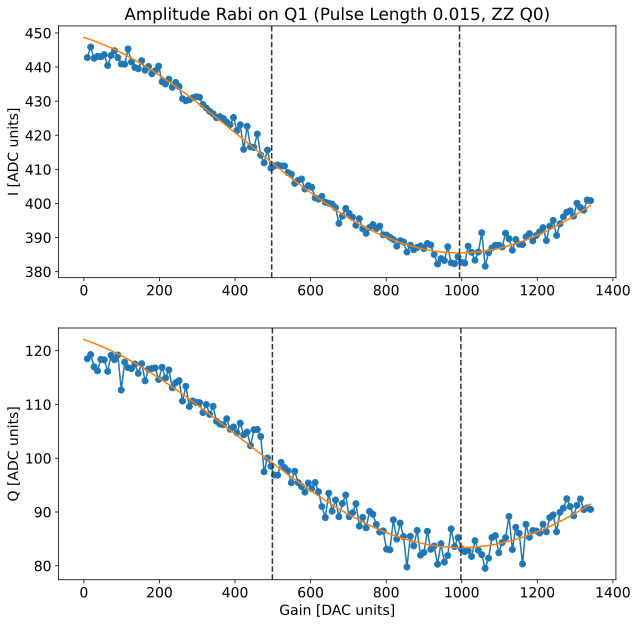

*Set Q1 pi pulse sigma with Q0 in e to 0.015*
*Set Q1 pi pulse gain with Q0 in e to 994*
-------- Ramsey --------


  0%|          | 0/40 [00:00<?, ?it/s]

Current pi pulse frequency: 3449.8780411921307
Fit frequency from amps [MHz]: 1.0301004710473638 +/- 0.0014847246452701435
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3449.8479407210834
 	3447.8479407210834
T2 Ramsey from fit amps [us]: 7.9174392456859275
Current pi pulse frequency: 3449.8780411921307
Fit frequency from I [MHz]: 1.0297857955771739 +/- 0.0018936898903526044
Suggested new pi pulse frequency from fit I [MHz]:
 	3449.8482553965537
 	3447.8482553965537
T2 Ramsey from fit I [us]: 6.584209151648328
Fit frequency from Q [MHz]: 1.0285686547841444 +/- 0.0017991365996219092
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3449.8494725373466
 	3447.8494725373466
T2 Ramsey from fit Q [us]: 7.467448370718211


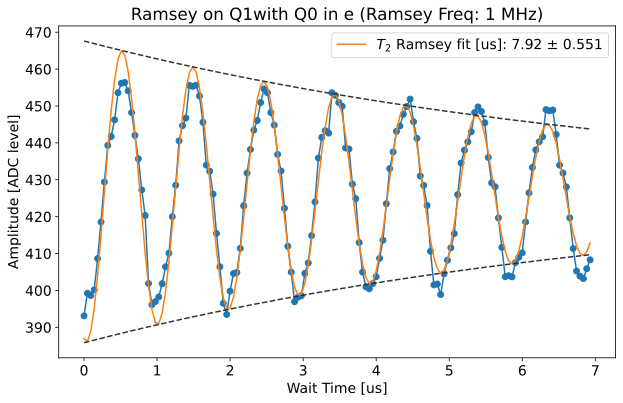

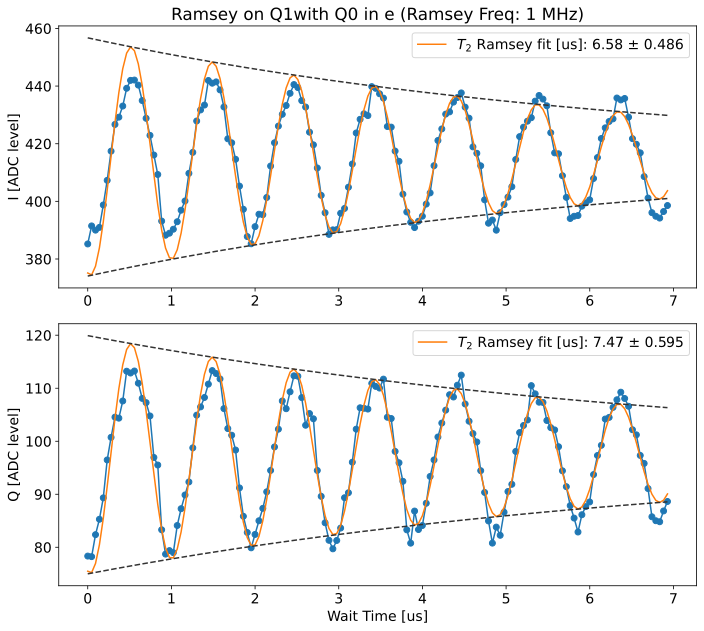

*Set Q1 pi pulse freq with Q0 in e to 3449.8479407210834*



######### BEGINNING QUBIT 2 #########
-------- length rabi --------


  0%|          | 0/101 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 184.93439999999998, which is out of bounds 0.43442424242424243 to 65.16363636363636. Instead init to 32.7990303030303
Decay from avgi [us] 0.15270865206678252
Pi length from avgi data [us]: 0.016340101244601897
	Pi/2 length from avgi data [us]: 0.008170050622300949

Decay from avgq [us] 0.1789407014817418
Pi length from avgq data [us]: 0.0164179926849078
Pi/2 length from avgq data [us]: 0.0082089963424539


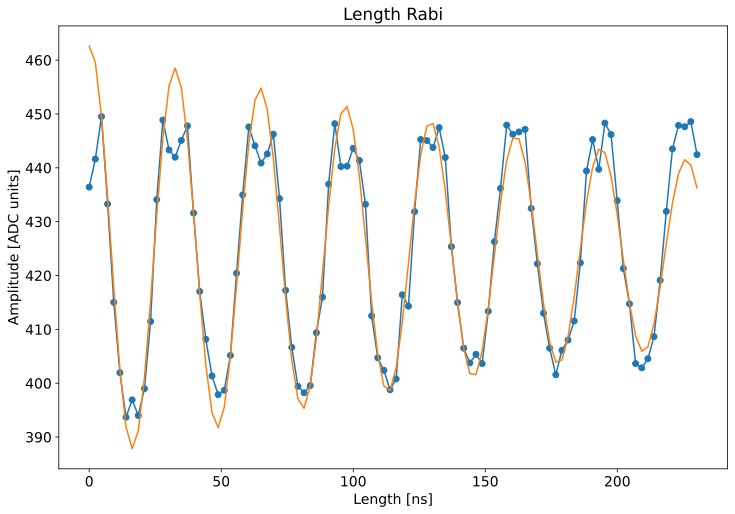

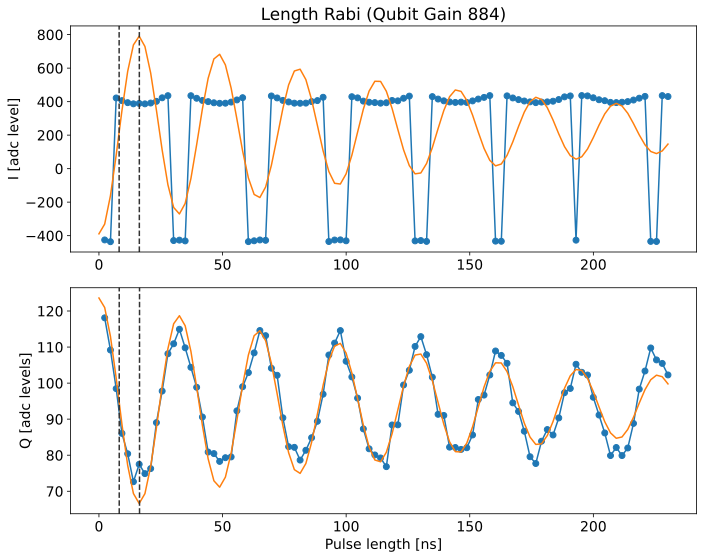

Will use sigma 0.015 for amplitude rabi
-------- Amp rabi --------
gauss


  0%|          | 0/30 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 959
	Pi/2 gain from amps data [dac units]: 479
Pi gain from avgi data [dac units]: 959
	Pi/2 gain from avgi data [dac units]: 479
Pi gain from avgq data [dac units]: 991
	Pi/2 gain from avgq data [dac units]: 495


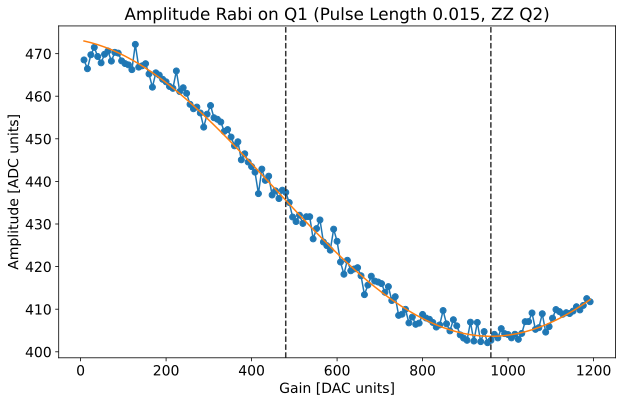

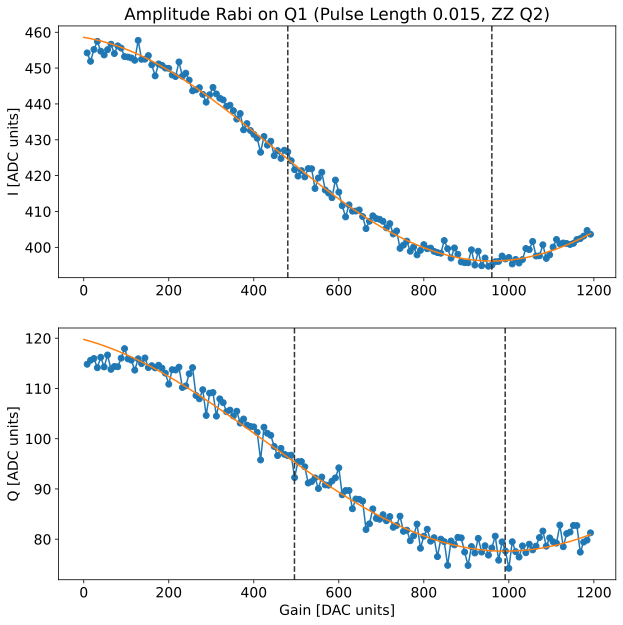

*Set Q1 pi pulse sigma with Q2 in e to 0.015*
*Set Q1 pi pulse gain with Q2 in e to 959*
-------- Ramsey --------


  0%|          | 0/40 [00:00<?, ?it/s]

Current pi pulse frequency: 3453.8227534521307
Fit frequency from amps [MHz]: 0.9127121757899268 +/- 0.001374534166415801
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3453.9100412763405
 	3451.9100412763405
T2 Ramsey from fit amps [us]: 7.566628546221223
Current pi pulse frequency: 3453.8227534521307
Fit frequency from I [MHz]: 0.912856131157235 +/- 0.001396573146024341
Suggested new pi pulse frequency from fit I [MHz]:
 	3453.9098973209734
 	3451.9098973209734
T2 Ramsey from fit I [us]: 7.555774730975908
Fit frequency from Q [MHz]: 0.9113632175952884 +/- 0.0017955368623991592
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3453.9113902345352
 	3451.9113902345352
T2 Ramsey from fit Q [us]: 6.777196672299474


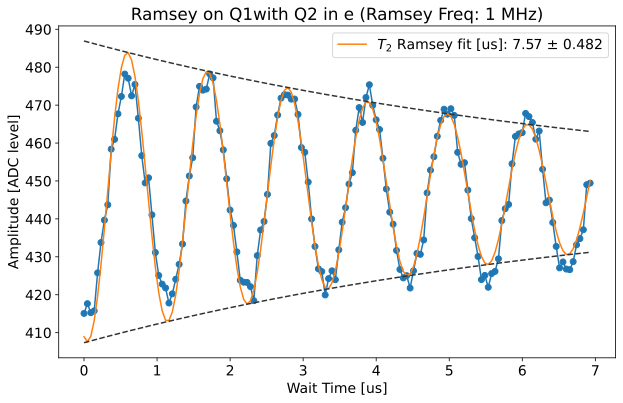

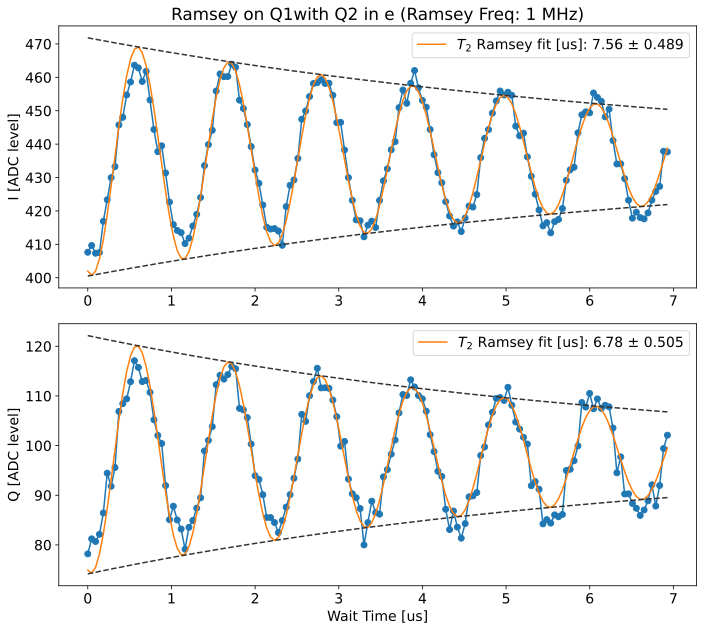

*Set Q1 pi pulse freq with Q2 in e to 3453.9100412763405*



######### BEGINNING QUBIT 3 #########
-------- length rabi --------


  0%|          | 0/101 [00:00<?, ?it/s]

Decay from avgi [us] 0.8086658603519891
Pi length from avgi data [us]: 0.016595443670947143
	Pi/2 length from avgi data [us]: 0.008297721835473571

Decay from avgq [us] 0.18740597263852768
Pi length from avgq data [us]: 0.016108969683145395
Pi/2 length from avgq data [us]: 0.008054484841572698


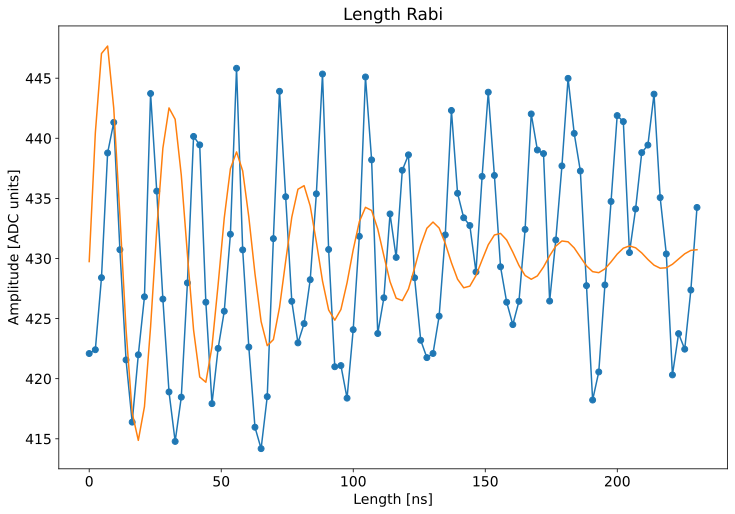

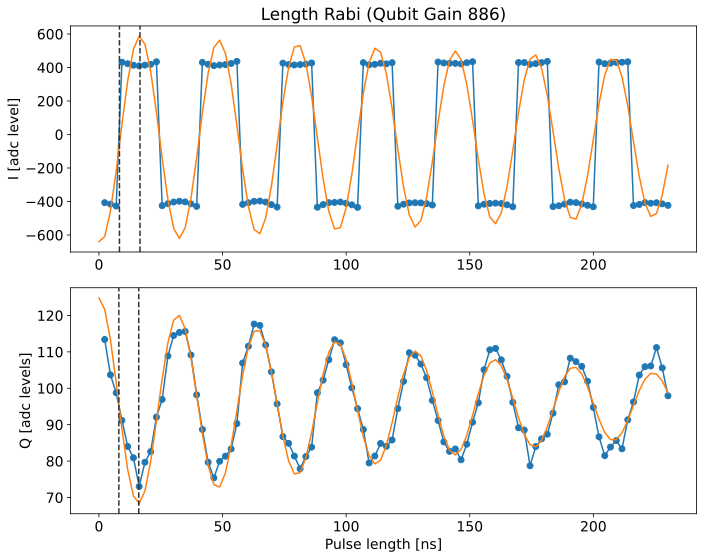

Will use sigma 0.015 for amplitude rabi
-------- Amp rabi --------
gauss


  0%|          | 0/30 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 950
	Pi/2 gain from amps data [dac units]: 475
Pi gain from avgi data [dac units]: 949
	Pi/2 gain from avgi data [dac units]: 474
Pi gain from avgq data [dac units]: 964
	Pi/2 gain from avgq data [dac units]: 482


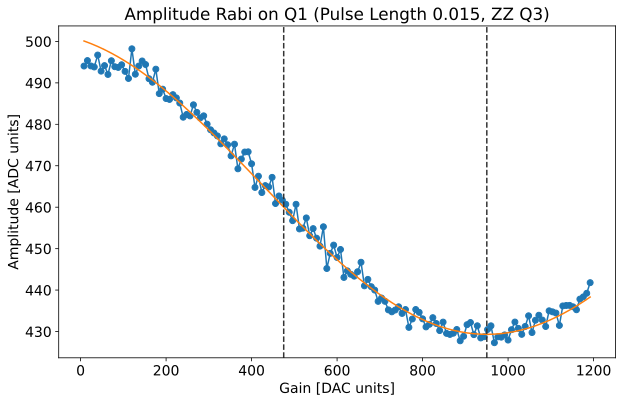

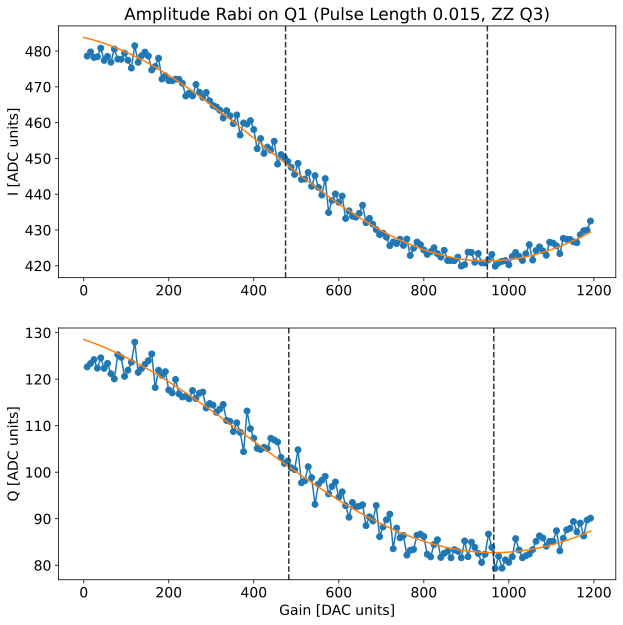

*Set Q1 pi pulse sigma with Q3 in e to 0.015*
*Set Q1 pi pulse gain with Q3 in e to 950*
-------- Ramsey --------


  0%|          | 0/40 [00:00<?, ?it/s]

Current pi pulse frequency: 3453.8635789221307
Fit frequency from amps [MHz]: 1.154926434996986 +/- 0.0019910896135789356
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3453.708652487134
 	3451.708652487134
T2 Ramsey from fit amps [us]: 5.725440139917245
Current pi pulse frequency: 3453.8635789221307
Fit frequency from I [MHz]: 1.1554469032293755 +/- 0.0015184195011384667
Suggested new pi pulse frequency from fit I [MHz]:
 	3453.7081320189013
 	3451.7081320189013
T2 Ramsey from fit I [us]: 6.891599461417527
Fit frequency from Q [MHz]: 1.1552866510739432 +/- 0.0021537880761615135
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3453.708292271057
 	3451.708292271057
T2 Ramsey from fit Q [us]: 6.098992693966635


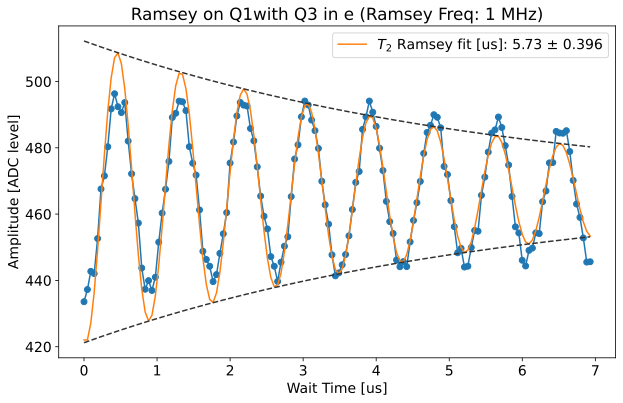

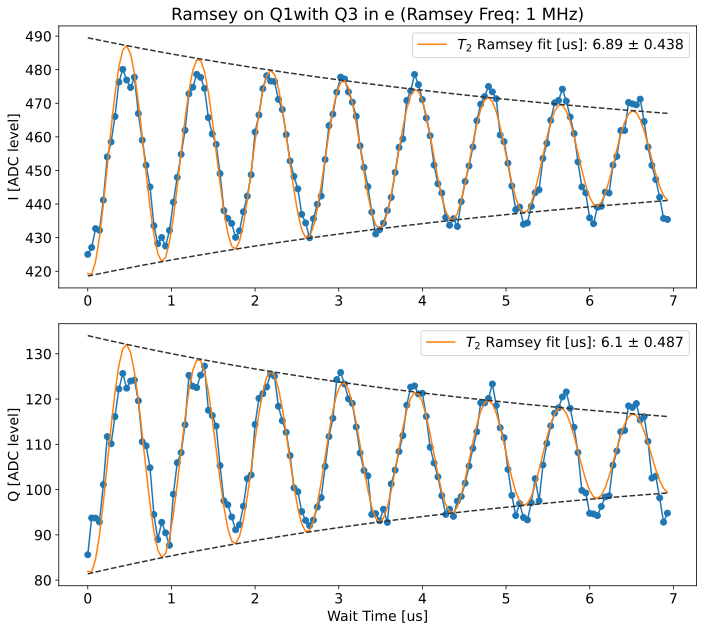

*Set Q1 pi pulse freq with Q3 in e to 3453.7081320189013*





In [26]:
try: save_data
except:
    assert False, 'you did not run the cell above!'
q1 = 1
# for q0 in [1, 2, 3]:
for q0 in range(4):
    if q0 == q1: continue

    print(f"######### BEGINNING QUBIT {q0} #########")

    print(f"-------- length rabi --------")
    lengthrabiZZ = meas.LengthRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_ZZ_qubit{q0}{q1}",
        config_file=config_path,
    )
    lengthrabiZZ.cfg = AttrDict(deepcopy(yaml_cfg))

    lengthrabiZZ.cfg.expt = dict(
        start=0, # pulse length (sigma) [us]
        step=soc.cycles2us(1), # [us]
        expts=101,
        reps=2000,
        gain=yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0],
        pulse_type='gauss',
        qubits=[q0, q1],
        checkZZ=True,
        checkEF=False, 
    )

    try:
        import Pyro4.util
        try:
            lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        lengthrabiZZ.analyze(fit=True)
    
        lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabiZZ.data)
    
        lengthrabiZZ.display(fit=True)
        p = lengthrabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
        else: pi_len = (3/2 - p[2]/180)/2/p[1]
        pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain
    
        lengthrabi_decay = p[3]

        print(f'Will use sigma {pi_len} for amplitude rabi')

        if save_data: saved_files.append(lengthrabiZZ.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! LENGTH RABI FAILED ON QUBIT {q0} !!!!!!!')
        continue

    print(f"-------- Amp rabi --------")
    amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{q0}{q1}",
        config_file=config_path,
    )
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]))
    npts = 151

    amprabi.cfg.expt = dict(
        start=0, # qubit gain [dac level]
        step=int(span/npts), # [dac level]
        expts=npts,
        reps=100,
        rounds=30,
        sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
        pulse_type='gauss',
        checkZZ=True,
        checkEF=False, 
        qubits=[q0, q1],
    )
    try:
        import Pyro4.util
        try:
            amprabi.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        amprabi.analyze(fit=True)

        amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

        p = amprabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
        else: pi_gain = (3/2 - p[2]/180)/2/p[1]

        if pi_gain > 32000:
            amprabi.display(fit=False)
            print('WARNING: Fit pi pulse gain is long, please double check!')
            pi_gain = 30000
        else: amprabi.display(fit=True)
        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = amprabi.cfg.expt.sigma_test

        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = pi_len
        results['sigma'][q0] =  pi_len
        print(f'*Set Q1 pi pulse sigma with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0]}*')

        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0] = int(pi_gain)
        results['gain'][q0] =  int(pi_gain)
        print(f'*Set Q1 pi pulse gain with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]}*')

        if save_data: saved_files.append(amprabi.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! AMP RABI FAILED ON QUBIT {q0} !!!!!!!')
        continue

    print(f"-------- Ramsey --------")
    ramsey = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{q1}",
        config_file=config_path,
    )
    ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
    ramsey.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(20), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        # step=0.05, # [us]
        expts=151,
        # expts=151,
        ramsey_freq=1, # [MHz]
        reps=100,
        rounds=40,
        checkZZ=True,
        checkEF=False,
        qubits=[q0, q1],
    )
    
    # ramsey.cfg.device.readout.relax_delay = 3*ramsey.cfg.device.qubit.T1[q1] # Wait time b/w expts [us]
    # ramsey.cfg.device.readout.gain = 0.15 # IT SEEMS HIGH PHOTON POPULATION CAN SOMETIMES MESS THIS UP
    
    try:
        ramsey.go(analyze=False, display=False, progress=True, save=False)
        ramsey.analyze(fit=True)

        ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

        ramsey.display(fit=True)
        new_pi_freq = ramsey.cfg.device.qubit.f_Q1_ZZ[q0] + ramsey_adjust[0]
        yaml_cfg.device.qubit.f_Q1_ZZ[q0] = new_pi_freq
        print(f'*Set Q1 pi pulse freq with Q{q0} in e to {yaml_cfg.device.qubit.f_Q1_ZZ[q0]}*')
        results['f_Q1_ZZ'][q0] =  new_pi_freq

        if save_data: saved_files.append(ramsey.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! RAMSEY FAILED ON QUBIT {q0}!!!!!!!')
        continue
    
    print("\n\n")

In [27]:
print('pi_Q1_ZZ')
print(results)
for saved_file in saved_files:
    print(saved_file)

{'gain': [994, 0, 959, 950], 'sigma': [0.015, 0, 0.015, 0.015], 'f_Q1_ZZ': [3449.8479407210834, 0, 3453.9100412763405, 3453.7081320189013]}


# ZZ shifted pi pulse calibrations for starting Q1 in e (pi_Q_ZZ1)

In [31]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_Q_ZZ1: [', end='')
print(*(ZZshifts[1] + yaml_cfg.device.qubit.f_ge[:]).flatten(), sep=', ', end=']\n')

UPDATE MANUALLY IN CONFIG:
f_Q_ZZ1: [4124.328859085333, 3454.9960740021306, 4778.422776960133, 4393.347912202836]


In [36]:
save_data = False
saved_files = []

In [37]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [38]:
results = dict(
    gain=[0]*4,
    sigma=[0]*4,
    f_Q_ZZ1=[0]*4,
    )

-------- Amp rabi --------
gauss


  0%|          | 0/30 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 27260
	Pi/2 gain from amps data [dac units]: 13630
Pi gain from avgi data [dac units]: 28064
	Pi/2 gain from avgi data [dac units]: 14032
Pi gain from avgq data [dac units]: 27582
	Pi/2 gain from avgq data [dac units]: 13791


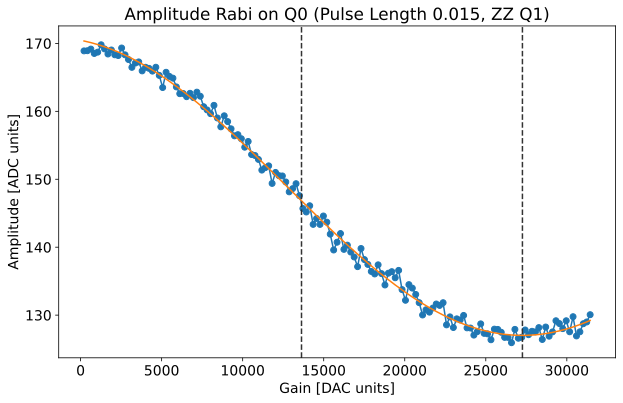

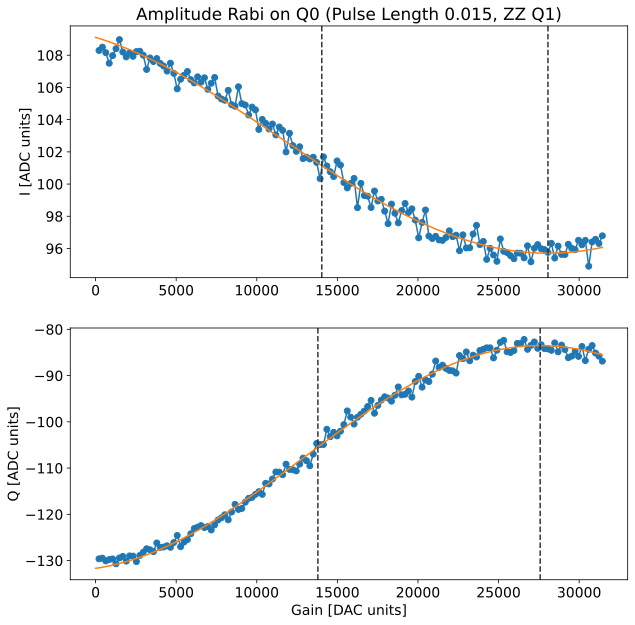

*Set Q0 pi pulse sigma with Q1 in e to 0.015*
*Set Q0 pi pulse gain with Q1 in e to 27582*
-------- Ramsey --------


  0%|          | 0/40 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 4.01408, which is out of bounds 0.01443221476510067 to 2.1648322147651005. Instead init to 1.0896322147651005
Attempted to init fitparam 1 to 4.01408, which is out of bounds 0.01443221476510067 to 2.1648322147651005. Instead init to 1.0896322147651005
Current pi pulse frequency: 4124.328859085333
Fit frequency from amps [MHz]: 1.0368233738018957 +/- 0.004248007244574757
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4124.292035711531
 	4122.292035711531
T2 Ramsey from fit amps [us]: 3.2178931198714276
Current pi pulse frequency: 4124.328859085333
Fit frequency from I [MHz]: 1.0376473043873953 +/- 0.005260724861695063
Suggested new pi pulse frequency from fit I [MHz]:
 	4124.291211780946
 	4122.291211780946
T2 Ramsey from fit I [us]: 2.9404460519635562
Fit frequency from Q [MHz]: 1.0383547653919203 +/- 0.0036287148335497977
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4124.290504319941
 	4122.290504319941
T2 Ramsey from fit Q [us]: 3.

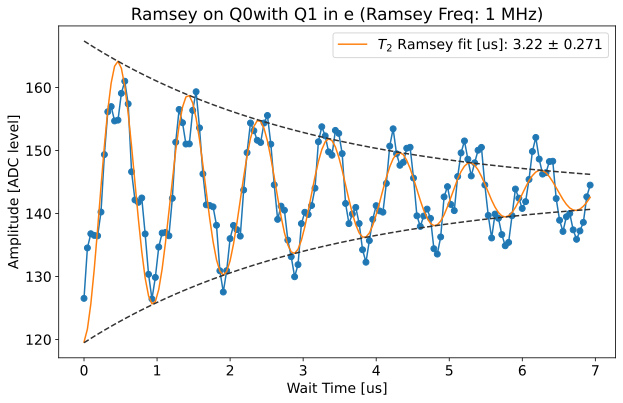

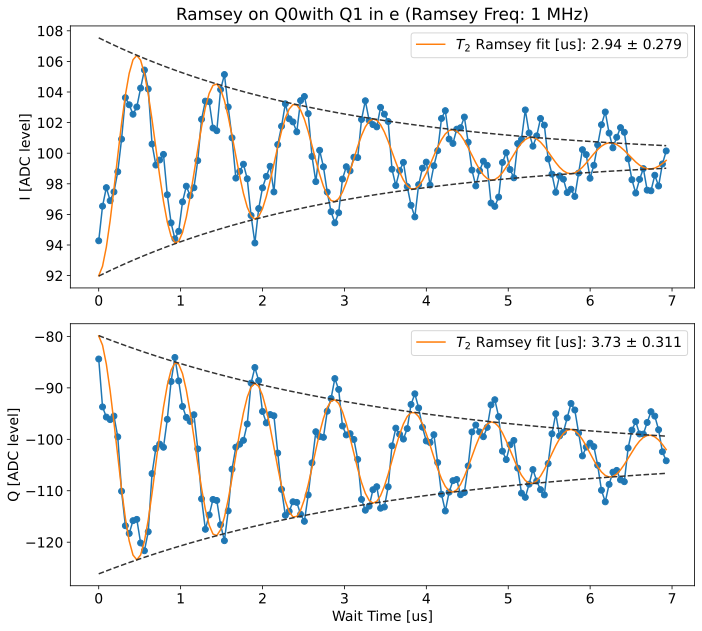

*Set Q0 pi pulse freq with Q1 in e to 4124.290504319941*



-------- Amp rabi --------
gauss


  0%|          | 0/30 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 2335
	Pi/2 gain from amps data [dac units]: 1167
Pi gain from avgi data [dac units]: 2334
	Pi/2 gain from avgi data [dac units]: 1167
Pi gain from avgq data [dac units]: 2340
	Pi/2 gain from avgq data [dac units]: 1170


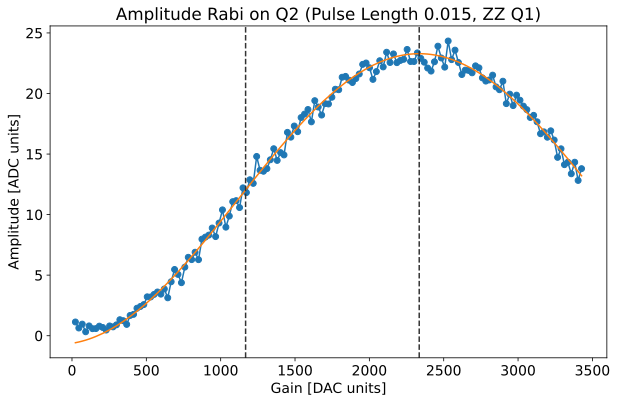

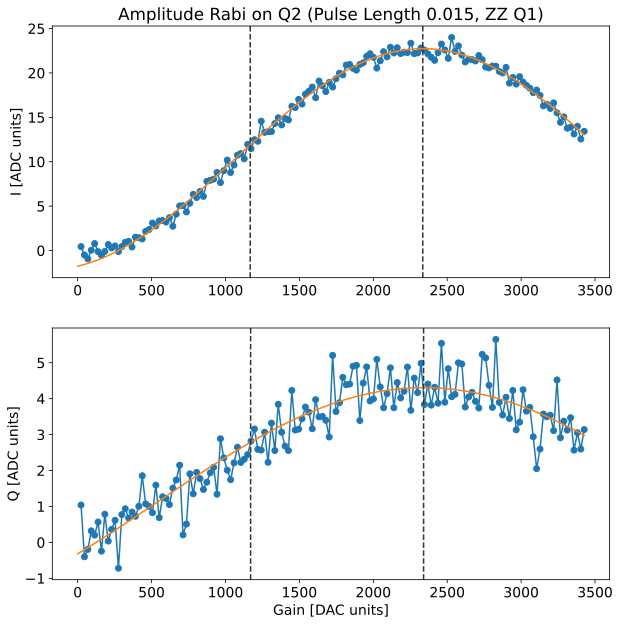

*Set Q2 pi pulse sigma with Q1 in e to 0.015*
*Set Q2 pi pulse gain with Q1 in e to 2335*
-------- Ramsey --------


  0%|          | 0/40 [00:00<?, ?it/s]

Current pi pulse frequency: 4778.422776960133
Fit frequency from amps [MHz]: 0.9204204373282907 +/- 0.0025737829018156744
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4778.502356522805
 	4776.502356522805
T2 Ramsey from fit amps [us]: 4.756233521988422
Current pi pulse frequency: 4778.422776960133
Fit frequency from I [MHz]: 0.9204209795053506 +/- 0.002586759576077408
Suggested new pi pulse frequency from fit I [MHz]:
 	4778.502355980628
 	4776.502355980628
T2 Ramsey from fit I [us]: 4.748561967351748
Fit frequency from Q [MHz]: 0.9188388958259879 +/- 0.005789553187397561
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4778.503938064307
 	4776.503938064307
T2 Ramsey from fit Q [us]: 3.3784063076486857


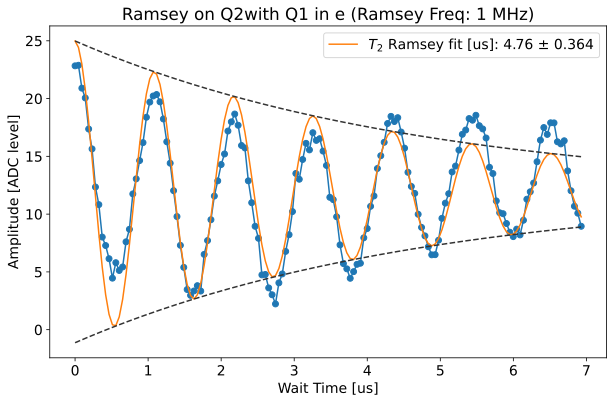

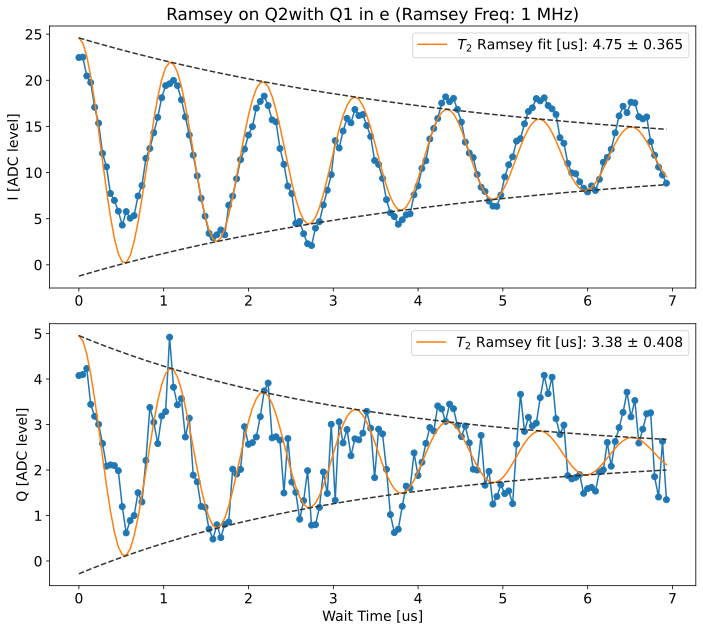

*Set Q2 pi pulse freq with Q1 in e to 4778.502356522805*



-------- Amp rabi --------
gauss


  0%|          | 0/30 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 2497
	Pi/2 gain from amps data [dac units]: 1248
Pi gain from avgi data [dac units]: 2496
	Pi/2 gain from avgi data [dac units]: 1248
Pi gain from avgq data [dac units]: 2497
	Pi/2 gain from avgq data [dac units]: 1248


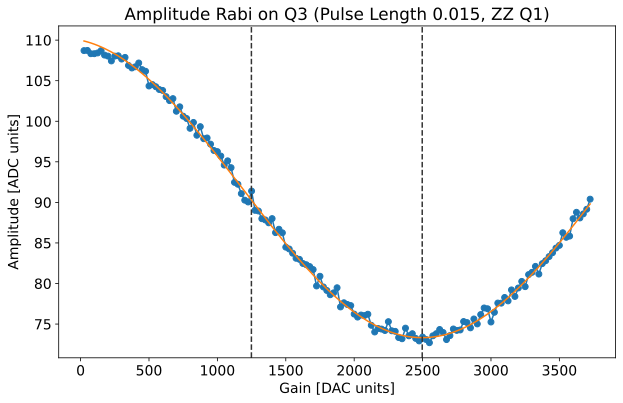

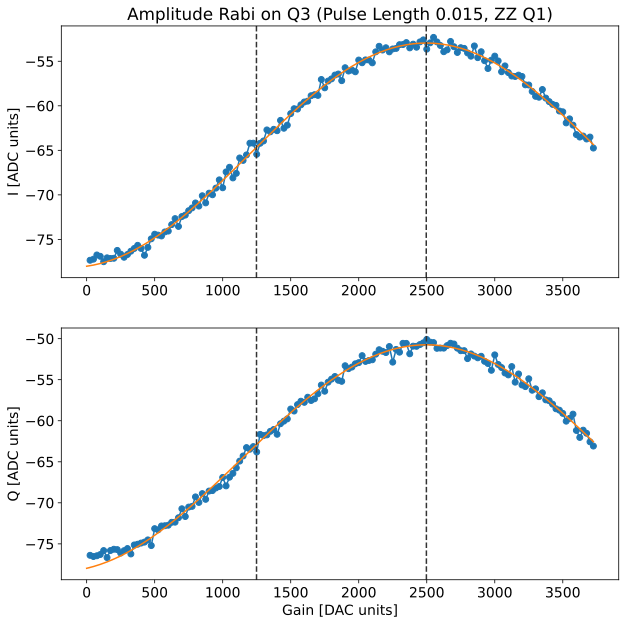

*Set Q3 pi pulse sigma with Q1 in e to 0.015*
*Set Q3 pi pulse gain with Q1 in e to 2496*
-------- Ramsey --------


  0%|          | 0/40 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 2.29376, which is out of bounds 0.01443221476510067 to 2.1648322147651005. Instead init to 1.0896322147651005
Current pi pulse frequency: 4393.347912202836
Fit frequency from amps [MHz]: 1.1363173648075682 +/- 0.004350186660068178
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4393.211594838028
 	4391.211594838028
T2 Ramsey from fit amps [us]: 2.337052157295011
Current pi pulse frequency: 4393.347912202836
Fit frequency from I [MHz]: 1.1387620721139242 +/- 0.00352107444289518
Suggested new pi pulse frequency from fit I [MHz]:
 	4393.209150130721
 	4391.209150130721
T2 Ramsey from fit I [us]: 2.7187222984865116
Fit frequency from Q [MHz]: 1.1400458866696495 +/- 0.003549677174127418
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4393.2078663161665
 	4391.2078663161665
T2 Ramsey from fit Q [us]: 2.782517512499215


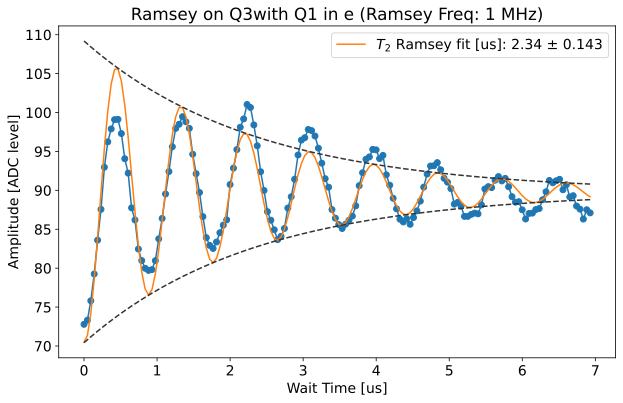

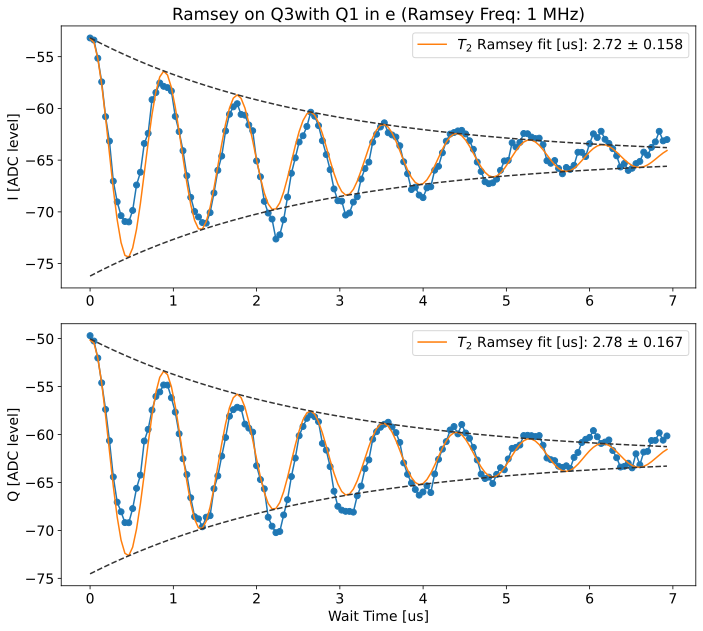

*Set Q3 pi pulse freq with Q1 in e to 4393.211594838028*





In [39]:
 # [x, 1] means test Q1 with ZZ from Qx; [1, x] means test Qx with ZZ from Q1, sort by Qx in both cases

try: save_data
except:
    assert False, 'you did not run the cell above!'
q0 = 1
# for q0 in [1, 2, 3]:
for qx in range(4):
    if qx == q1: continue

    print(f"-------- Amp rabi --------")
    amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{q0}{qx}",
        config_file=config_path,
    )
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx]))
    npts = 151

    amprabi.cfg.expt = dict(
        start=0, # qubit gain [dac level]
        step=int(span/npts), # [dac level]
        expts=npts,
        reps=100,
        rounds=30,
        sigma_test=yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qx], # gaussian sigma for pulse length - overrides config [us]
        pulse_type='gauss',
        checkZZ=True,
        checkEF=False, 
        qubits=[q0, qx],
    )
    try:
        import Pyro4.util
        try:
            amprabi.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        amprabi.analyze(fit=True)

        amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

        p = amprabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
        else: pi_gain = (3/2 - p[2]/180)/2/p[1]

        if pi_gain > 32000:
            amprabi.display(fit=False)
            print('WARNING: Fit pi pulse gain is long, please double check!')
            pi_gain = 30000
        else: amprabi.display(fit=True)
        yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qx] = amprabi.cfg.expt.sigma_test

        yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qx] = pi_len
        results['sigma'][qx] =  pi_len
        print(f'*Set Q{qx} pi pulse sigma with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qx]}*')

        yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx] = int(pi_gain)
        results['gain'][qx] =  int(pi_gain)
        print(f'*Set Q{qx} pi pulse gain with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx]}*')

        if save_data: saved_files.append(amprabi.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! AMP RABI FAILED ON QUBIT {qx} (Q{q0} in e) !!!!!!!')
        continue

    print(f"-------- Ramsey --------")
    ramsey = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{q0}{qx}",
        config_file=config_path,
    )
    ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
    ramsey.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(20), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        # step=0.05, # [us]
        expts=151,
        # expts=151,
        ramsey_freq=1, # [MHz]
        reps=100,
        rounds=40,
        checkZZ=True,
        checkEF=False,
        qubits=[q0, qx],
    )
    
    # ramsey.cfg.device.readout.relax_delay = 3*ramsey.cfg.device.qubit.T1[q1] # Wait time b/w expts [us]
    # ramsey.cfg.device.readout.gain = 0.15 # IT SEEMS HIGH PHOTON POPULATION CAN SOMETIMES MESS THIS UP
    
    try:
        ramsey.go(analyze=False, display=False, progress=True, save=False)
        ramsey.analyze(fit=True)

        ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

        ramsey.display(fit=True)
        new_pi_freq = ramsey.cfg.device.qubit.f_Q_ZZ1[qx] + ramsey_adjust[0]
        yaml_cfg.device.qubit.f_Q_ZZ1[qx] = new_pi_freq
        print(f'*Set Q{qx} pi pulse freq with Q{q0} in e to {yaml_cfg.device.qubit.f_Q_ZZ1[qx]}*')
        results['f_Q_ZZ1'][qx] = new_pi_freq

        if save_data: saved_files.append(ramsey.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! RAMSEY FAILED ON QUBIT {qx} (Q{q0} in e)!!!!!!!')
        continue
    
    print("\n\n")

In [41]:
print('pi_Q_ZZ1')
print(results)
for saved_file in saved_files:
    print(saved_file)

pi_Q_ZZ1
{'gain': [27582, 0, 2335, 2496], 'sigma': [0.015, 0, 0.015, 0.015], 'f_Q_ZZ1': [4124.290504319941, 0, 4778.502356522805, 4393.211594838028]}
